--------------------------------------------------------------------
ER background from materials. 
----------------------------------------------------------------
notebook can be run on the Freiburg cluster or on Dali. 
Change the path of files accordingly.
on dali files are on: /dali/lgrandi/xenonnt/simulations/er_simulations/rootfiles

In [134]:
print("loading....")
%run 'init.ipynb'
%run 'geometry_checks_en.ipynb'
%run '../functions.ipynb'
print("done!")
from scipy.optimize import curve_fit
components = ["PmtTpc",
             "OuterCryostat_Elongation",
             "OuterCryostatShell", 
             "OuterCryostat_flanges",
             "SS_InnerCryostatShell",
             "SS_InnerCryostatFlanges",
             "SS_InnerCryostat_bottomDome",
             "SS_BellPlate",
             "SS_BellSideWall",
             "SS_BellSideWallBottomLip",
             "Teflon_Pillar_",#includes also pfte frame (Lxe + Gxe part)
             "SS_AnodeRing", #anode + all the electrodes 
             "Teflon_TPC_Sliding", #material is Teflon_TPC used twice for sliding and fixed
             "Teflon_TPC_Fixed",
             "Teflon_BottomTPC",
             "Copper_TopRing", #includes also bottom ring
             "Copper_FieldGuard_",
              "Copper_FieldShaperRing_",
              "Copper_BottomPmtPlate" #includes also top ring
             ]

loading....
server chosen is: /userdata/arocchetti/rootfiles/
final date for contamination scaling:  2020-05-01
done!


In [135]:
def get_xyz(rootfile):
    dataframe = []
    for df in read_root(rootfile, "events/events", chunksize=1000000,
                             columns= ["xpri", "ypri", "zpri", "epri", "ns", "X", "Y", "Z", "Ed"],
                             where=("ns==1 & Ed > 2000 & Ed < 3000") ,
                            ):#, unit = "chunks"):
        #print(df.X)
        x_values=[x[0] for x in df.X]
        y_values=[y[0] for y in df.Y]
        z_values=[z[0] for z in df.Z]
        Ed_values = [Ed[0] for Ed in df.Ed]
        df["X"]=x_values
        df["Y"]=y_values
        df["Z"]=z_values
        df["Ed"]=Ed_values
        dataframe.append(df)
        if (len(dataframe)>0):
            dataframe=pd.concat(dataframe)
            dataframe.columns = ['xp', 'yp', 'zp_uc', "epri", "ns", "X", "Y", "Z_uc", "Ed"] #rename 
            offset = 1488/2
            dataframe['rp'] = np.sqrt(dataframe.xp**2+ dataframe.yp**2)
            dataframe['r2p'] = dataframe.rp*dataframe.rp
            dataframe['R'] = np.sqrt(dataframe.X**2+ dataframe.Y**2)
            dataframe['R2'] = (dataframe.R*dataframe.R)
            dataframe['Z'] = dataframe.Z_uc+offset
            dataframe['zp'] = dataframe.zp_uc+ offset

        break
        
    return dataframe

In [136]:
def load_data_and_normalize(param):
    if param == 1:
        df_ = pd.DataFrame()
        conv = 3.154e+7 #number of seconds in a year
        for component in components:
            print("working on:" , component)
            for i in range(0, len(isotope_array)):
                isotope = isotope_array[i]
                data, frac, material = get_data(isotope, component) 
                if len(data)>0:
                    N_ = number_of_events(material)
                    N = N_[isotope]
                    b = select_typepri(isotope) #later on with the good function
                    n =  N*(frac/100)*(1/b) #n_gen * fraction in that component * chain_factor 
                    p = scale_activity(component, final_date)
                    mass = p['mass']
                    contamination = p[isotope] 
                    if contamination > 0:
                        contamination = p[isotope]/1000 
                        time = n / (mass * contamination)
                        time_weights = [(1/time)*conv]*len(data)
                        isotope_name = [isotope]*len(data)
                        component_name = [component]*len(data)
                        data["weights"] = time_weights 
                        data["isotope"] = isotope_name
                        data["component"] = component_name
                        df_ = pd.concat([data, df_])
                    else:          
                        print("no contamination for ", isotope)
                        continue

                else:
                    print("no data for", isotope, component)
                    continue

        return df_
    else:
        print("reading pickle file")
        df_ = pd.read_pickle("normalized_dataframe.pkl")
        return df_

In [137]:
data = load_data_and_normalize(0)

reading pickle file


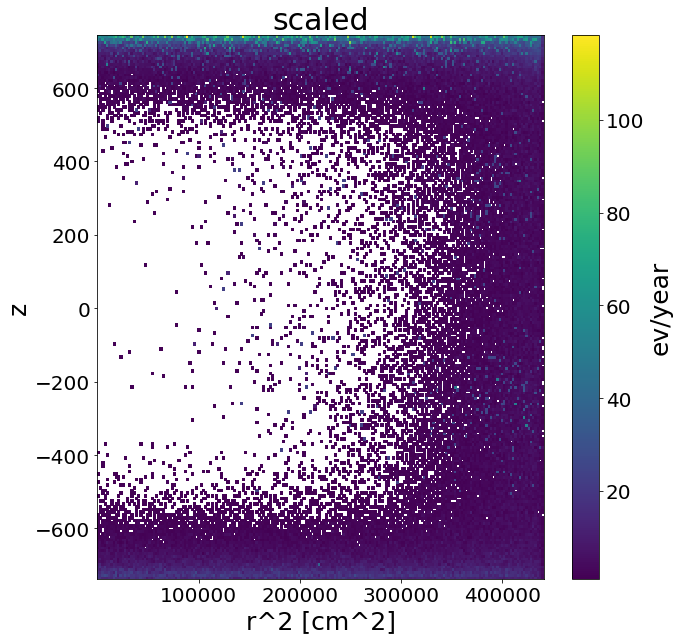

In [138]:
plt.figure(figsize = (10,10))
n=plt.hist2d(data.R2, data.Z, bins = (200,200), cmin = 1, Norm = LogNorm, weights = data.weights)
h = plt.colorbar()
h.set_label("ev/year")
plt.title("scaled")
plt.ylabel("z")
plt.xlabel("r^2 [cm^2]")
plt.show()


In [150]:
offset = 1488/2
data["uncor_z"] = data.Z
data["Z"]=data.Z-offset

en_range = 400  #keV 2.2 MeV Bi214 and the 2.6 MeV

data = data[data.Ed > 2200]
data = data[data.Ed < 2600]


In [151]:
minz = min(data.Z)
maxz = max(data.Z)
print(minz, maxz)

-2224.9576416015625 -744.197318777442


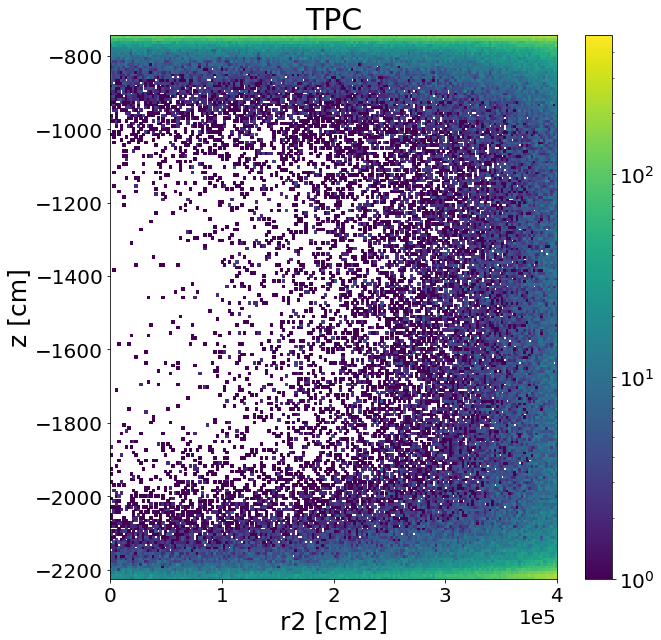

In [152]:
def plot_param_space(data):
    plt.figure(figsize = (10,10))
    cmap = "viridis"
    plt.hist2d(data.R2, data.Z, bins=(200, 200), norm = LogNorm())
    plt.colorbar()
    plt.xlim(0, 400e3)
    plt.ylim(minz, maxz)
    plt.xlabel("r2 [cm2]")
    plt.ylabel("z [cm]")
    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    plt.title("TPC")
    plt.show()
    
    
plot_param_space(data)

In [153]:
df = data.copy()

In [278]:
r_min = min(df.R2)
r_max = max(df.R2)

n_bins = 10

r2 = np.linspace(r_min,r_max,n_bins)

z_min = min(df.Z)
z_max = max(df.Z)
middle_1t = (-(z_max-z_min)/2)+z_max

z = np.linspace(z_min,z_max,n_bins)

R, Z = np.meshgrid(r2, z)

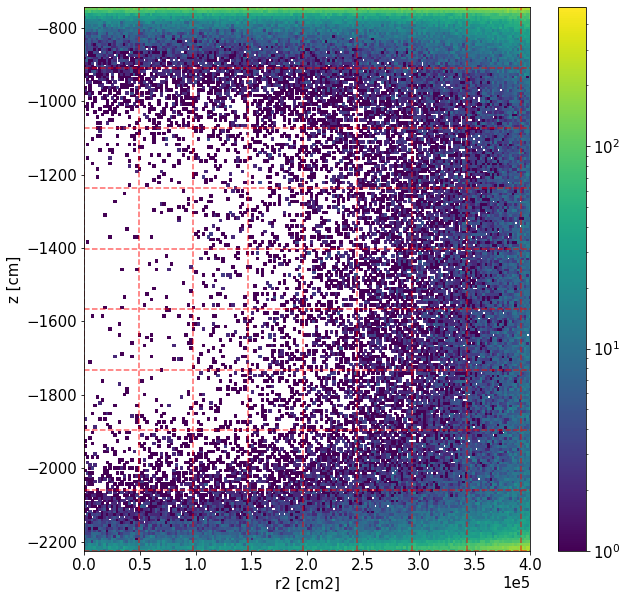

In [279]:
plt.figure(figsize = (10,10))
cmap = "viridis"
plt.hist2d(df.R2, df.Z, bins=(200, 200), norm = LogNorm())
plt.colorbar()
plt.xlim(0, 400e3)
plt.ylim(plt.ylim(minz, maxz))
plt.xlabel("r2 [cm2]")
plt.ylabel("z [cm]")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))


for i in range(len(r2)):
    plt.axvline(x=r2[i], color='r', alpha=0.6, linestyle='--')
for i in range(len(z)):
    plt.axhline(y=z[i], color='r', alpha=0.6, linestyle='--')

plt.show()

In [280]:
def figure_merit(z_low,z_high,r_low,r_high):
    m=1
    section = df[df.Z>z_low]
    section = section[section.Z<z_high]
    section = section[section.R2>r_low]
    section = section[section.R2<r_high]
    counts = len(section.weights) #to know how many events in each section, I just need to sum the weigths as each event counts as 1*weights. 
    figure = m/np.sqrt(counts)
    return figure#, counts


In [281]:
import pickle 
def calculate_fom(param, n_bins):
    if param == 1:
        print("calculating, be patient")
        Figure = np.zeros( (len(Z), len(R)) )
        Counts = np.zeros( (len(Z), len(R)) )
        for i in range(len(Z)-1):
            for j in range(len(R)-1):
                figure = figure_merit(Z[i][j],Z[i+1][j],R[i][j],R[i][j+1])
                Figure[i][j] = figure

        with open(f'Figure_{n_bins}.pkl','wb') as f:
            pickle.dump(Figure, f)
    else:
        print("reading the pickle")
        with open(f'Figure_{n_bins}.pkl','rb') as f:
            Figure = pickle.load(f)
    return Figure

In [282]:
Figure = calculate_fom(1, n_bins)

calculating, be patient


In [283]:
x_axis_labels = []
y_axis_labels = []
for i in R[0]:
    x_axis_labels.append(str(i))

for i in range(0,len(Z)):
    lab = Z[i][0]
    y_axis_labels.append(str(lab))    

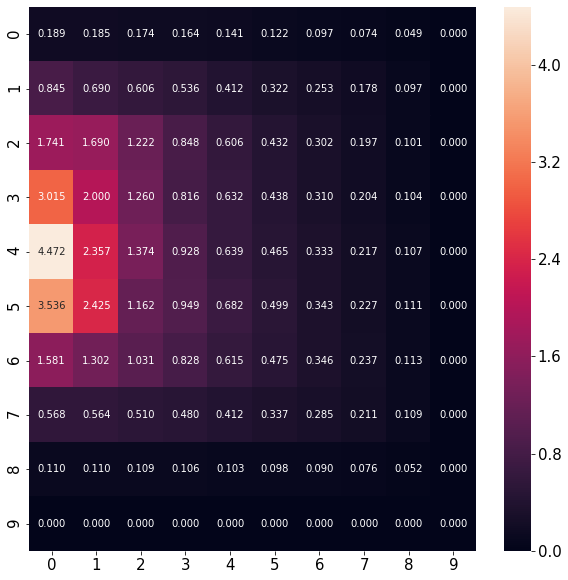

In [285]:
#need to format the lables and to add a note that this is the sensitivity*10
import seaborn as sns
plt.figure(figsize = (10,10))
from matplotlib.ticker import FormatStrFormatter
ax = sns.heatmap(Figure*10, annot=True, fmt = ".3f", 
                annot_kws={"size": 10}, #xticklabels=x_axis_labels, yticklabels=y_axis_labels
               )

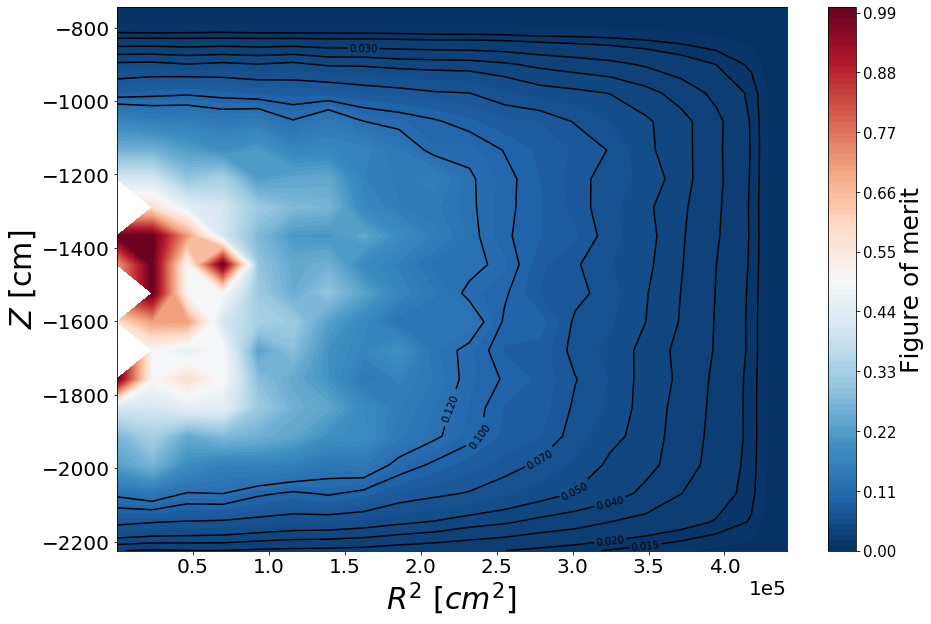

In [248]:
import matplotlib.ticker as ticker

plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
matplotlib.rcParams.update({'font.size': 25}) 

#levels=[0.045,0.038,0.025, 0.010, 0.005,0.001, 0.0001]
levels = [ 0.12,0.10, 0.07, 0.05, 0.04, 0.03, 0.02, 0.015] #0.015]
levels = levels[::-1]

h = plt.contourf(R,Z,Figure, 100, cmap='RdBu_r') #filled contours
c = plt.contour(R,Z,Figure, levels, colors='k') #levels
plt.clabel(c, inline=True, fontsize=10, colors='k')
plt.xlabel('$R^2$ [$cm^2$]',fontsize=30)
plt.ylabel('$Z}$ [cm]',fontsize=30)
cbar = plt.colorbar(h, label='Figure of merit')
cbar.ax.tick_params(labelsize=15) 
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

plt.show()

In [249]:
cont = c.allsegs #List of all the polygon segments for all the levels.
cont_r = []
cont_z = []

for j in range(len(cont)):
    r_column = []
    z_column = []
    
    for i in range(len(cont[j][0])):
        r_column.append(cont[j][0][i][0])
        z_column.append(cont[j][0][i][1])
        last_j = j
        last_i = i
    #else:
    #    r_column.append(cont[last_j][0][last_i][0])
    #    z_column.append(cont[last_j][0][last_i][1])
    
    cont_r.append(r_column)
    cont_z.append(z_column)

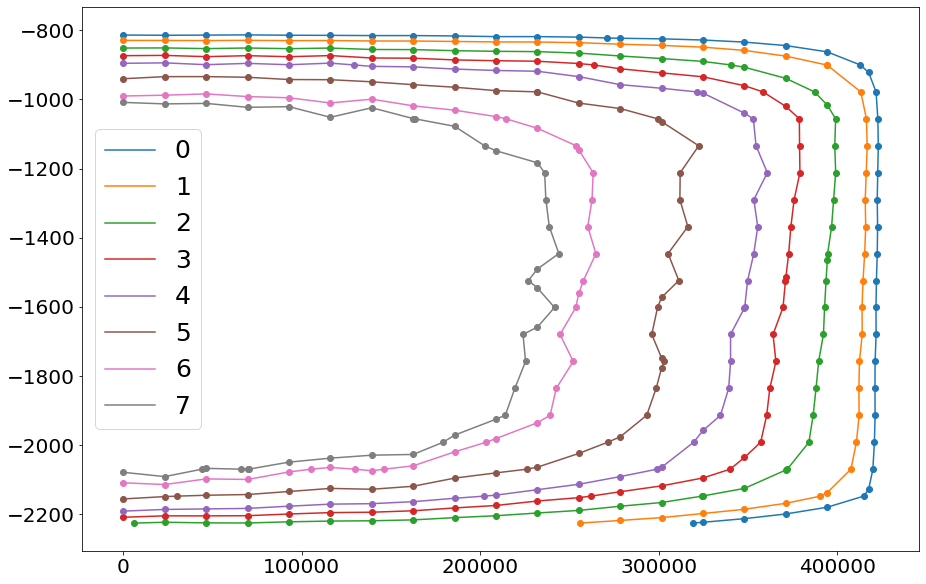

In [250]:
for i in range(0, len(cont)):
    plt.plot(cont_r[i], cont_z[i], label = f"{i}")
    plt.scatter(cont_r[i], cont_z[i])
    plt.legend()
    #print(i, len(cont_r[i]))

In [251]:
def ellipsoid(z,r,zmin,zmax,p):
    vz = np.abs((zmin - zmax)/2)
    z0 = zmax - vz
    return r * np.power( (1- (np.absolute(z-z0)/vz)**p) , 1/p) 

Ellipsoid with 4 free parameters:
- the minimum (or maximum) Z,
- the difference between maximum and minimum, 
- the maximum radius
- shape parameter.

In [252]:
tpc_length = 1488
print(tpc_length)
def SuperEllipseUpperZs(x, zloc, zscale, r2scale, power_const):
    Zs = np.power(
        1. - np.power(
            x/r2scale,
            power_const
        ),
        1./power_const
    )*zscale+zloc
    line = -tpc_length
    #return np.maximum(Zs,line)
    return Zs

def SuperEllipseUpperZs_2(x, zloc, zscale, r2scale, power_const):
    Zs = np.power(
        1. - np.power(
            x/r2scale,
            power_const
        ),
        1./power_const
    )*zscale+zloc
    line = -tpc_length
    return np.maximum(Zs,line)


def SuperEllipseLowerZs(x, zloc, zscale, r2scale, power_const):
    Zs = -np.power(
        1. - np.power(
            x/r2scale,
            power_const
        ),
        1./power_const
    )*zscale+zloc
    line = -tpc_length
    return np.maximum(Zs, line)
    
#zloc, zscale, r2scale, power_const
popt_lowers = [0, 2000, 3365.00009977, 3]

popt_uppers = [0, 16.35006807, 3366.99766348, 3]

1488


In [254]:
from scipy.integrate import quad

def fit_ellipsoid(df, z, r2, func_up, func_low, t1, t2):
    tpc_length = (max(data.Z)- min(data.Z))
    z_min = min(z)
    z_max = max(z)
    z_diff = (z_max-z_min)
    r_2 = max(r2)
    idx = np.argmax(r2)
    
    z_min_fit = np.minimum(z_min, -tpc_length)
    
    plt.scatter(r2[:idx],z[:idx], color=col[i]) 
    plt.scatter(r2[idx:],z[idx:], color=col[i])
    init_up = [z_min_fit,z_diff,r_2,t1]
    init_low = [z_max,z_diff,r_2,t2]
    
    fitparup, fitcovup = curve_fit(func_up, r2[:idx+1], z[:idx+1], init_up, 4.8*np.ones(len(z[:idx+1])))
    fitparlow, fitcovlow = curve_fit(func_low, r2[idx:], z[idx:], init_low, 4.8*np.ones(len(z[idx:])))
  
    y_up = func_up(r2[:idx+1], *fitparup)
    y_down = func_low(r2[idx:], *fitparlow)
    
    plt.plot(r2[:idx+1], y_up)
    plt.plot(r2[idx:], y_down)
    
    # Integrals method
    I_low, err_low = quad(func_low, 0, r_2, args=(fitparlow[0],fitparlow[1],fitparlow[2],fitparlow[3]))
    I_up, err_up = quad(func_up, 0, r_2, args=(fitparup[0],fitparup[1],fitparup[2],fitparup[3]))
    volume_I = np.pi*(I_low-I_up)
    mass_I = (volume_I*rho_xenon)/1000
    print('Integral method:')
    print('Volume = ', volume_I,'cm^3 --> Mass = ', mass_I, 'kg')
   
    #we select the area in the ellipsoids
    df_in = df[df.Z < func_low(df.R2,fitparlow[0],fitparlow[1],fitparlow[2],fitparlow[3])]
    df_in = df_in[df_in.Z > func_up(df_in.R2,fitparup[0],fitparup[1],fitparup[2],fitparup[3])]
    
    bkg_counts = len(df_in.weights)
    print('counts = ', bkg_counts)
    
 
    Mass = mass_I
    figure_of_merit = Mass/np.sqrt(bkg_counts)
    print('Figure of merit =',figure_of_merit)
    print('----------------------------------------------------')
    
    return fitparup, fitparlow, figure_of_merit, Mass

In [256]:
rho_xenon = 2.862 #[g/cm3]
n_contour = len(cont_r)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in power


Integral method:
Volume =  708324782.2496886 cm^3 --> Mass =  2027225.526798609 kg
counts =  2974
Figure of merit = 37173.340016339345
----------------------------------------------------
[ 2.23856410e+06 -2.24063170e+06  6.02713669e+05  6.90884575e+00]
Integral method:
Volume =  822184150.5462302 cm^3 --> Mass =  2353091.0388633106 kg
counts =  4473
Figure of merit = 35183.51949538315
----------------------------------------------------
[ 4.92654610e+04 -5.13440282e+04  3.33120195e+05  9.40375879e+00]
Integral method:
Volume =  1085731490.8748612 cm^3 --> Mass =  3107363.526883853 kg
counts =  10814
Figure of merit = 29881.258268829737
----------------------------------------------------
[ 4.57695341e+06 -4.57907721e+06  5.21498906e+05  1.22271508e+01]
Integral method:
Volume =  1323512932.0463927 cm^3 --> Mass =  3787894.011516776 kg
counts =  22330
Figure of merit = 25348.569575247835
----------------------------------------------------
[ 3.20421963e+06 -3.20637777e+06  5.16817933e+

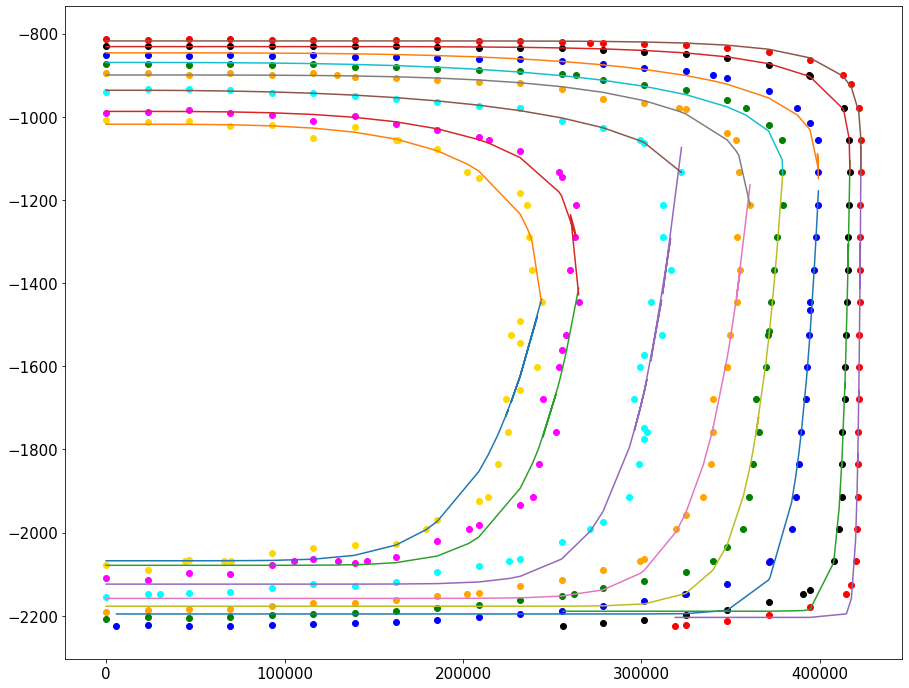

In [275]:
plt.rcParams['figure.figsize'] = (15, 12)

col = ['r','k','b','g','orange','cyan','magenta','gold','purple','indigo']

n_contour = len(cont_r)

fom = []
mass = []

for i in range(0, n_contour)[::-1]:
#for i in range(0,4):
    p1=3
    p2=2
    par_up, par_low, figure_of_merit, Mass = fit_ellipsoid(df, cont_z[i], cont_r[i],
                                                           SuperEllipseUpperZs, SuperEllipseLowerZs, p1,p2)

    print(par_up)
    fom.append(figure_of_merit)
    mass.append(Mass)

Text(0, 0.5, 'FoM in the Volume')

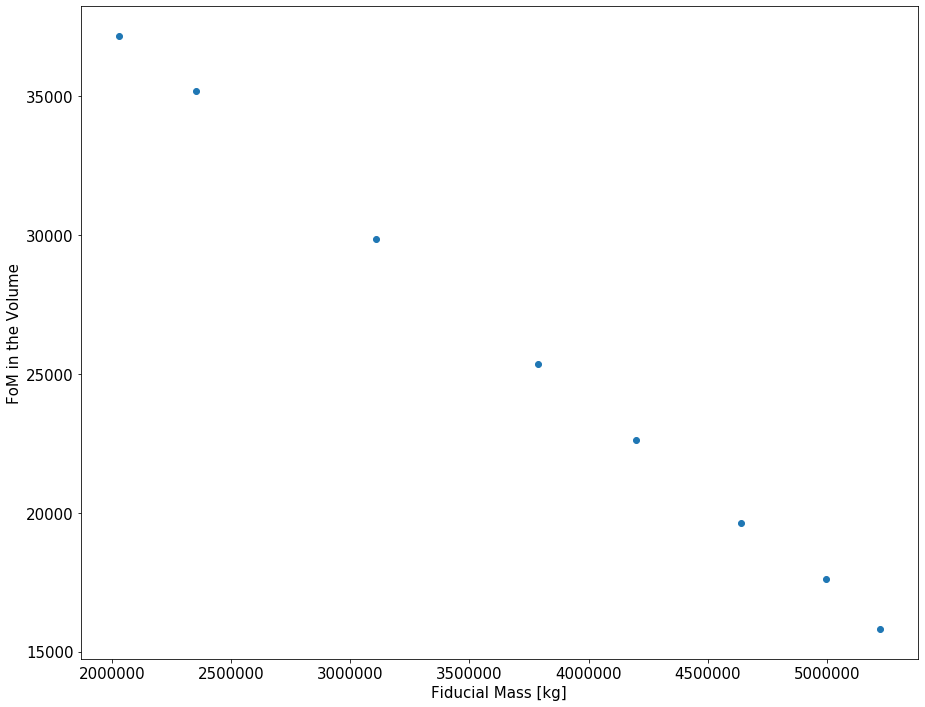

In [276]:
plt.scatter(mass, fom)
plt.xlabel('Fiducial Mass [kg]')
plt.ylabel('FoM in the Volume')

contour fom: 0.015 --> Fiducial Mass = 2027.225526798609
contour fom: 0.02 --> Fiducial Mass = 2353.0910388633106
contour fom: 0.03 --> Fiducial Mass = 3107.363526883853
contour fom: 0.04 --> Fiducial Mass = 3787.894011516776
contour fom: 0.05 --> Fiducial Mass = 4200.180923978396
contour fom: 0.07 --> Fiducial Mass = 4638.94738783159
contour fom: 0.1 --> Fiducial Mass = 4998.503933924132
contour fom: 0.12 --> Fiducial Mass = 5223.357101211018


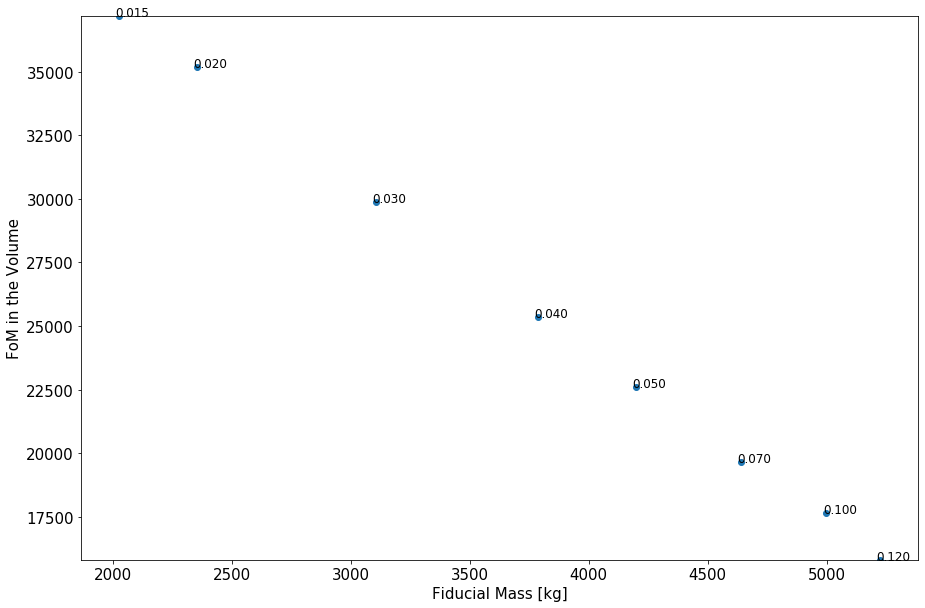

In [277]:
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
matplotlib.rcParams.update({'font.size': 15}) 

mass = np.array(mass)
mass = mass/1000

plt.scatter(mass, fom)
plt.xlabel('Fiducial Mass [kg]')
plt.ylabel('FoM in the Volume')

for i in range(len(mass)):
    plt.text(mass[i]-15, fom[i]-0.035, '%5.3f' % levels[i],
             fontsize=12,rotation=0, color='k')
    print('contour fom:',levels[i], '--> Fiducial Mass =',mass[i])

plt.ylim([min(fom)-0.05,max(fom)+0.05])
plt.show()